




---


# ChestXRAY Model project - Development based on CNN (Convolutional Neural Network)
### Supervised Learning approach

### Goal
The goal of this works is to create a _Model_ based on  CNN (_convolutional neural network_) to be able to classify X-Ray images in three distinct category ‘**normal**’, ‘**bacterial pneumonia**’ ou ‘**viral pneumonia**’.

---

### Layout change
The original directory name and the images name was edited to get a clean and well organized dataset, to facilitate the manipulation on python.

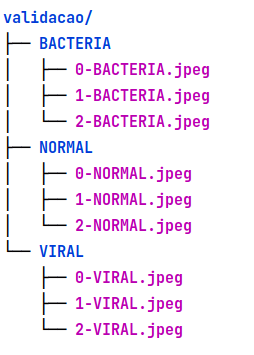
Figure-1.0 | Update Layout

---

### Hyperparamters


Value related to the siz of images (on running processes)
+ **imageSize = 224**

Initial coephitient to calculate the Stochastic Gradient Descendet 1e-4 = 0.0001
+ **INIT_LR = 1e-4**

Total size of training set of the Neural Network (the ideal number based on a few tests)
+ **EPOCHS = 20**

(batch size) Value graet than 1 and divisible for total size of the dataset
+ **BS = 40**





### Python classes ordenation

Python classes classificaton  (*Array Python*) **NORMAL**, **BACTERIA PNEUMONIA** e **VIRAL PNEUMONIA**


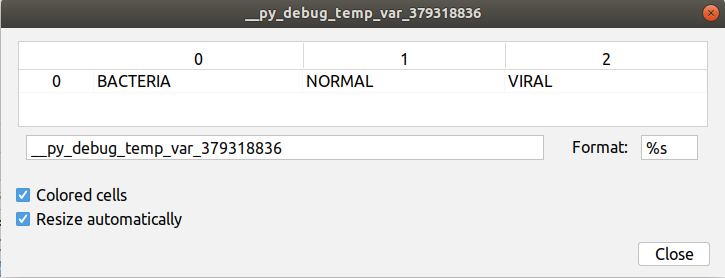


### Model metrics

As final metric number the model get *80%* of accuracy, if we considere the dataset caracteristics and the diversity and the classes distinction (_the close caracteristics_) as final result we get an apressive number of accuracy

The total time of the training the CNN (_20 epochs_) was close to 25 minutes, using a laptop setup with _Core i7 9˚gen, 12 nucleus, 32GB RAM memory_


_**PS:** this time was get running the python scprips via linux terminal (command line), running by jupyther notebook the procces run two time more to get the same result_


---

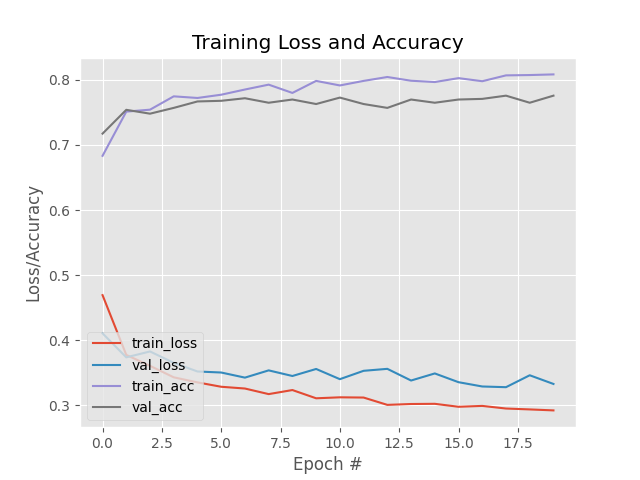

**Precision** = It is the quality of a positive prediction made by the model


**Recall** =  It is the metric to measure the proportion of actual positives that was identified correctly.

**F1-Score** = It combines the precision and recall scores of a model. Basically the accuracy metric computes how many times a model made a correct prediction across the entire


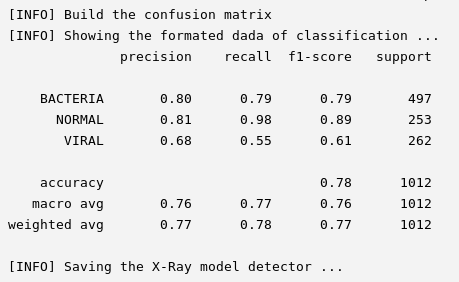


### Confusion Matrix

The Confusion matrix show the predicted model capabilities to classifies as **NORMAL** it is close to 98%, wheareas the **VIRAL** classification has a high indices error associeted to **BACTERIA** classe.
Perhaps, the reason might be the level of noising on the images.
Another fact that it is important to enfatisize is the size of the Dataset (small dataset) that contribut/influence the model cabalities to distinguish the classes **VIRAL** and **BACTARIA** badly

The confusion matrix below shows 

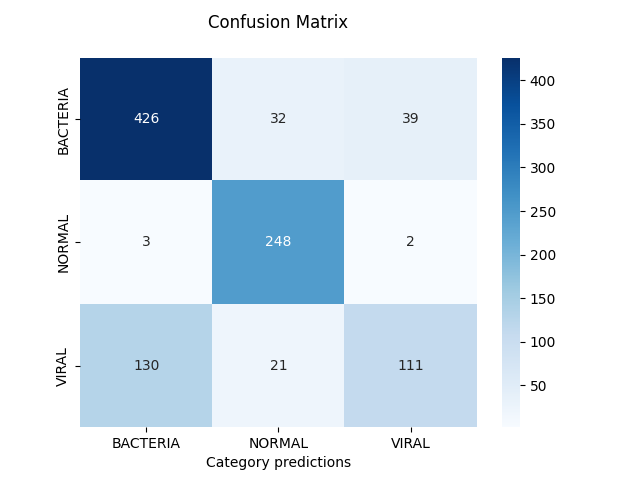

---


# Initial setup

**1. Open the terminal (this set up was made on Ubuntu 22).**

**2. Install the graphviz graphics dependence.**
+ sudo apt install graphviz

**3. Create the virtual environment.**
+ python3 -m venv venv

**4. Activate the virtual environment.**
+ source venv/bin/activate

**5. Install all lib dependences running the command below.**
+ pip install -r requirements.txt

## ChestXRAY classificator

The classification process is organized in a few methods below.


---

# 1st Step - training


#### List of all dependeces imported

In [1]:
from keras.applications import MobileNetV2
from keras.applications.densenet import preprocess_input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, to_categorical, plot_model
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imutils import paths
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

---

## Training methods


#### Data Augmentation descrption
Data augmentation is a technique used to create copy from an orginal image and run an update on its angule,zoom in, rotation, etc. 


The _Data Augmentation_ was used to boost the dataset diversity, helping the traing processe to build a more accurate model.

##### Method responsable for difine the dataAugmentation properties.

In [ ]:
def dataAugmentatio():
    aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    return aug

In [3]:
def baseModelArc():
    """ Method responsible for create the core architecture of the network and its parameters.
    """

    #Transfer learning approach is used (imagenet wights)
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
                            input_tensor=Input(shape=(224, 224, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel) # Up to 128 neuron on the hidden layer
    headModel = Dropout(0.2)(headModel) # All neurons that achive less than 20% of wight, doesn't pass for the next layer
    headModel = Dense(3, activation="softmax")(headModel) #Outpout with 3 layers

    # Creating the model ( Loop over all layers on the base model where they not will be update within the first traning step.)
    model = Model(inputs=baseModel.input, outputs=headModel)

    return model, baseModel

In [4]:
def trainingModel(aug, model, trainX, trainY, testX, testY):
    H = model.fit(
        aug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        epochs=EPOCHS)
    return H

#### Method that compile the training metrics over the traing processes

In [1]:
def plotMetrics(H):

    N = EPOCHS
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("acuracia_final.png")

In [6]:
def confusionMatrix(testY, predIdxs):

    test_Y = np.argmax(testY, axis=1)
    cf_matrix = confusion_matrix(test_Y, predIdxs)
    heat_map = sb.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="d")
    heat_map.set_title('Confusion Matrix\n');
    heat_map.set_xlabel('Category predictions\n\n')
    heat_map.xaxis.set_ticklabels(['BACTERIA', 'NORMAL', 'VIRAL'])
    heat_map.yaxis.set_ticklabels(['BACTERIA', 'NORMAL', 'VIRAL'])
    plt.savefig("confusion_matrix.png")

#### Main method that execute the training model.

In [7]:
def training(imagePaths, imageSize, data, labels):

    print("[INFO] Loading the imagens to process than ...")

    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]
        #print("####: {}".format(label))

        # load the input image (224x224) and preprocess it
        image = load_img(imagePath,
                         target_size=(imageSize, imageSize))  # Loads an image into PIL format. (PIL it is a Pythin library)
        image = img_to_array(image)
        image = preprocess_input(image)  # Pre-processing steps include resizing to 224×224 pixels, conversion to array format,
        # and scaling the pixel intensities in the input image to the range [-1, 1]
        # (via the preprocess_input convenience function)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)

    # Convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels)

    lb = LabelEncoder()
    labels = lb.fit_transform(labels)
    
    # Creates a matrix of binary labels
    print("### Categories/classes in matrix format:  {}".format(labels))
    labels = to_categorical(labels)

    # Separete the data to train and test, the percentage seted was 80%(train) - 20%(test)
    (trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                      test_size=0.20, stratify=labels, random_state=42)
    # Data Augmentation
    aug = dataAugmentatio()

    # Creats the base architecture of the model
    model, baseModel = baseModelArc()

    for layer in baseModel.layers:
        layer.trainable = False

    # Model compilation
    print("[INFO] Compiling the model...")
    opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer=opt,
                  metrics=["accuracy"])

    plot_model(model, show_shapes=True, show_layer_names=True, rankdir="LR", expand_nested=True, dpi=True)

    # Model training (train the head of the network)
    print("[INFO] Using data augmetation on model training ...")
    H = trainingModel(aug, model, trainX, trainY, testX, testY)

    # Executing prediction tests
    print("[INFO] Checking the network (running the prediction tests) ...")
    predIdxs = model.predict(testX, batch_size=BS)

    # For each image on test set, it is finding the index label that containg the high prediction probability.
    predIdxs = np.argmax(predIdxs, axis=1)

    print("[INFO] Build the confusion matrix")
    confusionMatrix(testY, predIdxs)

    print("[INFO] Showing the formated dada of classification ...")
    print(classification_report(testY.argmax(axis=1), predIdxs,
                                target_names=lb.classes_))
    # Save the model on H5 format
    print("[INFO] Saving the X-Ray model detector ...")
    model.save("chestxray_3C.model", save_format="h5")

    # Ploting the training data
    plotMetrics(H)

[INFO] Carregando as imagens para processamento ...
### Categorias/classes em forma de matriz:  [1 1 1 ... 2 2 2]
[INFO] Compilando o modelo...
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.589685 to fit

[INFO] Utilizando data augmetation no treinamento do modelo ...
Epoch 1/20
101/101 [==============================] - 94s 930ms/step - loss: 0.4742 - accuracy: 0.6651 - val_loss: 0.3835 - val_accuracy: 0.7342
Epoch 2/20
101/101 [==============================] - 94s 932ms/step - loss: 0.3764 - accuracy: 0.7352 - val_loss: 0.3333 - val_accuracy: 0.7806
Epoch 3/20
101/101 [==============================] - 89s 882ms/step - loss: 0.3480 - accuracy: 0.7577 - val_loss: 0.3196 - val_accuracy: 0.7866
Epoch 4/20
101/101 [==============================] - 89s 877ms/step - loss: 0.3428 - accuracy: 0.7639 - val_loss: 0.3182 - val_accuracy: 0.7895
Epoch 5/20
101/101 [==============================] - 88s 872ms/step - loss: 0.3326 - accuracy: 0.7744 - val_loss: 0.3040 - val_accu

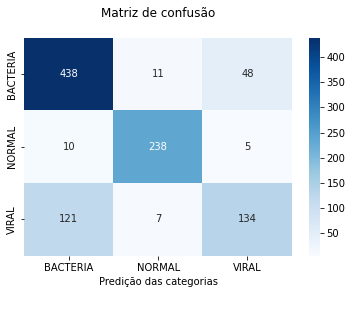

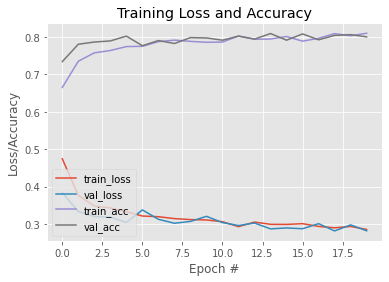

<Figure size 432x288 with 0 Axes>

In [8]:
if __name__ == '__main__':

    # Object and constants
    PATH_TRAIN = "../dataset/chest_xray/training"
    imagePaths = list(paths.list_images(PATH_TRAIN))
    data = []
    labels = []

    # Hyperparameters
    imageSize = 224
    INIT_LR = 1e-4  # Initial value of coefficient to calculate the Stochastic Gradient Descendent 1e-4 = 0.0001
    EPOCHS = 20  # Total neuralnetwork training per steps
    BS = 40  # Value bigger than one and divided by the size of dataset.

    training(imagePaths, imageSize, data, labels)

---


# 2nd step - Classification

In [10]:
def classification(image_path, dir_name):
    IMAGE_SIZE = 224
    image = load_img(image_path,
                     target_size=(
                     IMAGE_SIZE, IMAGE_SIZE))  
    
    image = img_to_array(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    index = np.argmax(predictions)
    
    print("[INFO] Classificando as imagens do diretório: {}".format(dir_name))

    if(index == 0):
        print("::RaioX Analisado: {}".format(dir_name))
        print("Classificado como: {}".format(LABELS[index]))
        print(":::::::::Acurácia: %.2f" % predictions[0][index])
        print("--------------------------------------------------------------------")
    elif(index == 1):
        print("::RaioX Analisado: {}".format(dir_name))
        print("Classificado como: {}".format(LABELS[index]))
        print(":::::::::Acurácia: %.2f" % predictions[0][index])
        print("--------------------------------------------------------------------")
    else:
        print("::RaioX Analisado: {}".format(dir_name))
        print("Classificado como: {}".format(LABELS[index]))
        print(":::::::::Acurácia: %.2f" % predictions[0][index])
        print("--------------------------------------------------------------------")



In [1]:
def get_images_validation(dir):
    path = PATH_VALIDATION + dir + FORMAT

    for image in glb.glob(path):
        classification(image, dir)

In [12]:
def get_dir_validation():
    for dir in DIRETORIOS:
        get_images_validation(dir)

In [13]:
if __name__ == '__main__':
    
    # Constantes e variáveis
    NORMAL = "NORMAL"
    PNEUMONIA_BACTERIA = "PNEUMONIA_BACTERIA"
    PNEUMONIA_VIRAL = "PNEUMONIA_VIRAL"
    LABELS = ['BACTERIA', 'NORMAL', 'VIRAL']
    PATH_VALIDATION = "../dataset/chest_xray/validacao/"
    DIRETORIOS = ['BACTERIA/', 'NORMAL/', 'VIRAL/']
    FORMAT = "*.jpeg"

    print("[INFO] Carregando o modelo para realizar a predição ...")
    model = load_model("../model/chestxray_3C.model")
    
    #Método responsável por obter os diretórios de cada classe de imagens
    get_dir_validation()

[INFO] Carregando o modelo para realizar a predição ...
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: NORMAL
:::::::::Acurácia: 0.56
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.64
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: VIRAL
:::::::::Acurácia: 0.53
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.79
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acu

[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.81
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.67
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.90
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.85
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: BACTERIA/
::RaioX Analisado: BACTERIA/
Classificado como: BACTERIA
:::::::::Acurácia: 0.70
---------------------------------------

[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 1.00
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 1.00
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 1.00
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 1.00
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 0.94
--------------------------------------------------------------------


[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 0.99
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 0.99
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 1.00
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: NORMAL/
::RaioX Analisado: NORMAL/
Classificado como: NORMAL
:::::::::Acurácia: 0.99
--------------------------------------------------------------------
[INFO] Classificando as imagens do diretório: VIRAL/
::RaioX Analisado: VIRAL/
Classificado como: NORMAL
:::::::::Acurácia: 0.92
--------------------------------------------------------------------
[I